# PA001: Airbnb

# Planejamento da solução (IOT)

# Input - Entrada 
   

## O problema de negócio

 1. Mapear as previsões de escolha de destino aos usuários de uma plataforma de locação de hospedagem.

# Output - Saída

## Modelo de Previsão para escolha do primeiro destino do usuário.


   1.0. Predições serão salvas em uma tabela do banco de dados.

   2.0. API

   Input: usuários e suas características;

   Output: usuários e suas características com a predição do destino;

# Tasks - Processo

 * New York City Airbnb Open Data:
 * https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data/code
 * Airbnb listings and metrics in NYC, NY, USA (2019)
    

*- Compreensão do modelo de negócio do Airbnb*
   - Marketplace ( Conectar pessoas que oferecem acomodação, com pessoas que estão procurando acomodação).
 
    
*- Usuários oferecem acomodações*
   - Tamanho do portfólio.
   - Diversidade/Densidade de Portfólio.
   - Preço Médio

*- Alta demanda* (usuário que não desejam hotel).
   - Número de Usuários
   - LTV ( Lifetime Value )
   - CAC ( Client Acquisition Cost )
   - Gross Revenue = ( Fee*Número cliente ) - CAC 

# Imports

In [1]:
import pandas as pd
from sklearn import model_selection as ms
from sklearn import preprocessing  as pp
from sklearn import metrics         as m
from scikitplot import metrics      as mt

from keras import models as ml
from keras import layers as l

/home/ehgeraldo/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-08-24 22:22:57.727942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-24 22:22:57.727976: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Helper Functions

## Loading Data

In [11]:
pwd

'/home/ehgeraldo/repos/airbnb'

In [2]:
# load data
df_raw = pd.read_csv('/home/ehgeraldo/repos/airbnb/data/train_users.csv')

# Data Description

In [3]:
df1 = df_raw.copy()

### Data dimensions

In [4]:
print( 'Number of rows:    {}'.format( df_raw.shape[0] ) )
print( 'Number of columns: {}'.format( df_raw.shape[1] ) )

Number of rows:    213451
Number of columns: 16


### Data types

In [19]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### Check NAs

In [15]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

### Replace NAs

In [16]:
df1 = df1.dropna()
df1.shape

(68171, 16)

In [17]:
print('Removed data: {:.2f}%'.format( 1-(df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.68%


In [18]:
df1.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [19]:
# date_account_created : (object -> datetime)
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active : (int64 -> datetime)
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking : (object -> datetime)
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age : (float64 -> int64)
df1['age'] = df1['age'].astype( int )

/tmp/ipykernel_4290/3264500397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )


In [20]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [21]:
df1.sample().T

,39784
id,z5ma53l0w6
date_account_created,2012-09-06 00:00:00
timestamp_first_active,2012-09-06 17:05:42
date_first_booking,2013-06-12 00:00:00
gender,MALE
age,35
signup_method,facebook
signup_flow,0
language,en
affiliate_channel,direct


## 1.4. Check Balanced Data

In [22]:
df1['country_destination'].value_counts( normalize=True )

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 2.0. Data Filtering

In [23]:
df2 = df1.copy()

## 2.1. Filtering Rows

## 2.2. Columns Selection

# 3.0. Data Preparation

In [24]:
df3 = df2.copy()

In [25]:
df3.shape

(68171, 16)

In [26]:
# dummy variable
df3_dummy = pd.get_dummies( df3.drop( ['id', 'country_destination'], axis=1 ) )

# join id and country destination
df3 = pd.concat( [df3[['id','country_destination']], df3_dummy], axis=1 )

In [27]:
df3.shape

(68171, 117)

# 4.0. Feature Selection

In [28]:
# Remove columns irelevants to training models 
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] # original dates
df4 = df3.drop( cols_drop, axis=1 )

In [29]:
df4.sample().T

,186704
id,ja0a3a9cv1
country_destination,US
age,65
signup_flow,0
gender_-unknown-,0
...,...
first_browser_Sogou Explorer,0
first_browser_Stainless,0
first_browser_TenFourFox,0
first_browser_TheWorld Browser,0


# 5.0. Machine Learning Model  - Neural Network MLP

In [30]:
# Select data to train and test or "train, validation, test"

# On X_train drop to 'country_destination' response variable 
x = df4.drop( 'country_destination', axis=1 )

# On y_train include 'country_destination'
y = df4['country_destination'].copy()

In [31]:
x.head(3)

,id,age,signup_flow,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,...,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser
2,4ft3gnwmtx,56,3,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,42,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,41,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
y.head(3)

2       US
3    other
4       US
Name: country_destination, dtype: object

In [33]:
# Split dataset into training and test
#80% train and 20% test

X_train, X_test, y_train, y_test = ms.train_test_split( x, y, test_size=0.2, random_state=32 )

In [34]:
X_train.head()

,id,age,signup_flow,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,...,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser
22531,b9eperouva,22,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
139247,6eqkvzq32e,63,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
170612,8wtjbmxmb3,35,25,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2995,floutkfa37,28,3,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
73845,4au7h23zsl,30,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Drop id to dataset

x_train = X_train.drop('id',axis=1)
x_test = X_test.drop('id', axis=1)

In [36]:
X_train.shape

(54536, 113)

In [37]:
X_test.shape

(13635, 113)

In [38]:
# One hot encoding (categoric variables -> numeric variables)

ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [39]:
y_train_nn

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [42]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 128, input_dim= x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 11, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

2022-08-24 22:27:01.348503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-24 22:27:01.348542: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-24 22:27:01.348567: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ehgeraldo-VirtualBox): /proc/driver/nvidia/version does not exist
2022-08-24 22:27:01.349903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
1705/1705 [==============================] - 8s 4ms/step - loss: 1.3191 - accuracy: 0.7067
Epoch 2/100
1705/1705 [==============================] - 9s 6ms/step - loss: 1.2725 - accuracy: 0.7076
Epoch 3/100
1705/1705 [==============================] - 7s 4ms/step - loss: 1.2372 - accuracy: 0.7067
Epoch 4/100
1705/1705 [==============================] - 8s 5ms/step - loss: 1.2145 - accuracy: 0.7084
Epoch 5/100
1705/1705 [==============================] - 8s 5ms/step - loss: 1.1862 - accuracy: 0.7085
Epoch 6/100
1705/1705 [==============================] - 8s 5ms/step - loss: 1.1771 - accuracy: 0.7085
Epoch 7/100
1705/1705 [==============================] - 9s 5ms/step - loss: 1.1600 - accuracy: 0.7087
Epoch 8/100
1705/1705 [==============================] - 6s 4ms/step - loss: 1.1474 - accuracy: 0.7087
Epoch 9/100
1705/1705 [==============================] - 6s 4ms/step - loss: 1.1427 - accuracy: 0.7087
Epoch 10/100
1705/1705 [==============================] - 9s 6ms/step - l

1705/1705 [==============================] - 6s 4ms/step - loss: 1.0975 - accuracy: 0.7119
Epoch 80/100
1705/1705 [==============================] - 9s 5ms/step - loss: 1.0969 - accuracy: 0.7121
Epoch 81/100
1705/1705 [==============================] - 6s 4ms/step - loss: 1.0970 - accuracy: 0.7120
Epoch 82/100
1705/1705 [==============================] - 6s 3ms/step - loss: 1.0970 - accuracy: 0.7124
Epoch 83/100
1705/1705 [==============================] - 6s 4ms/step - loss: 1.0964 - accuracy: 0.7122
Epoch 84/100
1705/1705 [==============================] - 7s 4ms/step - loss: 1.0961 - accuracy: 0.7123
Epoch 85/100
1705/1705 [==============================] - 7s 4ms/step - loss: 1.0960 - accuracy: 0.7124
Epoch 86/100
1705/1705 [==============================] - 6s 4ms/step - loss: 1.0960 - accuracy: 0.7123
Epoch 87/100
1705/1705 [==============================] - 7s 4ms/step - loss: 1.0952 - accuracy: 0.7124
Epoch 88/100
1705/1705 [==============================] - 6s 4ms/step - loss:

## 5.1. NN Performance

In [44]:
y_train

22531        US
139247       FR
170612       IT
2995         US
73845        US
          ...  
165842       US
71991     other
59064        US
187388       IT
30096        US
Name: country_destination, Length: 54536, dtype: object

In [45]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn   = yhat_nn.reshape( 1, -1 )[0]

427/427 [==============================] - 2s 3ms/step


In [46]:
yhat_nn

array(['US', 'US', 'other', ..., 'US', 'US', 'US'], dtype=object)

In [47]:
y_test_nn

array(['US', 'US', 'US', ..., 'US', 'US', 'US'], dtype=object)

In [48]:
m.balanced_accuracy_score( y_test_nn, yhat_nn )

0.09160544686067232

Accuracy: 0.7037770443711038
Balanced Accuracy:0.09160544686067232
Kappa Score:0.0012470863083833272


/home/ehgeraldo/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ehgeraldo/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ehgeraldo/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.50      0.01      0.01       170
          ES       0.00      0.00      0.00       345
          FR       0.29      0.00      0.01       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.15      0.00      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.15      0.09      0.08     13635
weighted avg       0.54      0.70      0.58     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

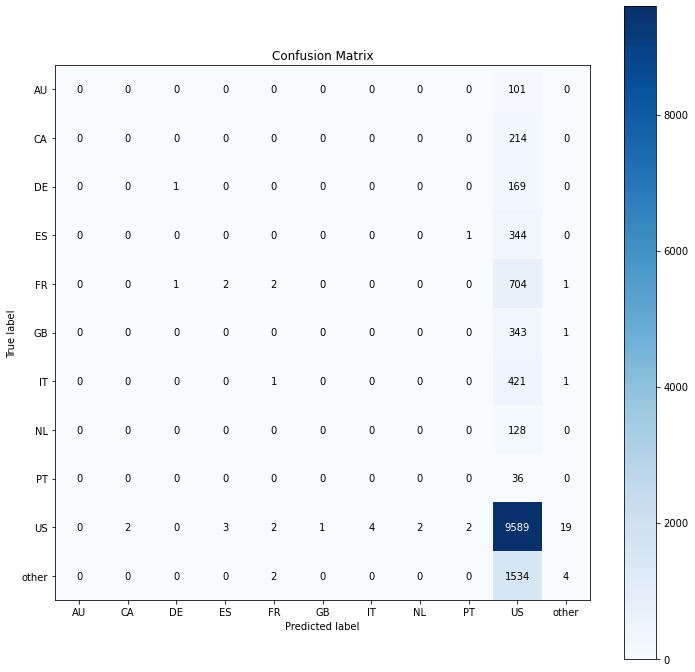

In [52]:
# Accuracy (right/correct predict)
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print( 'Accuracy: {}'.format( acc_nn ) )


# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
print( 'Balanced Accuracy:{}'.format( balanced_acc_nn) )


# Kappa Metrics
kappa_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
print( 'Kappa Score:{}'.format( kappa_nn ) )


# Classification report
print( m.classification_report( y_test_nn, yhat_nn ) )


# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12))